<a href="https://colab.research.google.com/github/Muse-M/FinalYearProject/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet

## Imports

In [5]:
!pip install onnx

In [6]:
# Pytorch imports
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# General Python imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import pickle
from datetime import datetime

# Quality of life imports
from tqdm.notebook import tqdm # progress Bar
from accelerate import Accelerator

# Models to transfer learn from
#import spender

# data normlisation (i'm used to )
from sklearn.preprocessing import MinMaxScaler

# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter
# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
################UoA code################
torch.manual_seed(42) # Setting the seed

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device cpu


## Dataloader + Visualisation

In [8]:
dataPath='/content/drive/MyDrive/Many QSO + Red'
filePaths=[]
for i in os.listdir(dataPath):
  filePaths.append(os.path.join(dataPath, i))

In [9]:
from concurrent.futures import ThreadPoolExecutor
def load_pickle(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        data['wl'] = data['wl'].flatten()
        df=pd.DataFrame(data)
        df_single_row = pd.DataFrame({col: [df[col].tolist()] for col in df.columns})
        return df_single_row

# Load files in parallel (take 1 minute on collab GPU)
with ThreadPoolExecutor() as executor:
    dataframes = list(executor.map(load_pickle, filePaths))


final_df = pd.concat(dataframes, ignore_index=True)
final_df.shape

(5000, 5)

In [10]:
firstDataset=final_df.copy(deep=True)
firstDataset['f_gal'] = firstDataset['f_gal'].apply(lambda x: x[0])

In [11]:
display(firstDataset.head())
firstDataset.info()

,wl,flux,true_AGN,true_gal,f_gal
0,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.4305741987984584, 1.431725648298067, 1.4223...","[1.3674232957237922, 1.369593308176218, 1.3613...","[0.06315090307466624, 0.06213234012184904, 0.0...",0.12
1,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.362473713630679, 1.3565544303962112, 1.3564...","[1.2521940987661142, 1.2480535189972037, 1.249...","[0.11027961486456486, 0.10850091139900736, 0.1...",0.22
2,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[0.7306849400019793, 0.7275536389725389, 0.721...","[0.4889902095338589, 0.48975721060874305, 0.48...","[0.24169473046812034, 0.2377964283637958, 0.23...",0.56
3,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[0.914212257359007, 0.9123390238969352, 0.9074...","[0.7333175788036334, 0.7343620014472934, 0.732...","[0.18089467855537367, 0.17797702244964184, 0.1...",0.39
4,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.2958520664965687, 1.2874874600494957, 1.279...","[1.2327011634219025, 1.2253551199276467, 1.218...","[0.06315090307466624, 0.06213234012184904, 0.0...",0.12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wl        5000 non-null   object 
 1   flux      5000 non-null   object 
 2   true_AGN  5000 non-null   object 
 3   true_gal  5000 non-null   object 
 4   f_gal     5000 non-null   float64
dtypes: float64(1), object(4)
memory usage: 195.4+ KB


No. of Wavelength bins =  1890


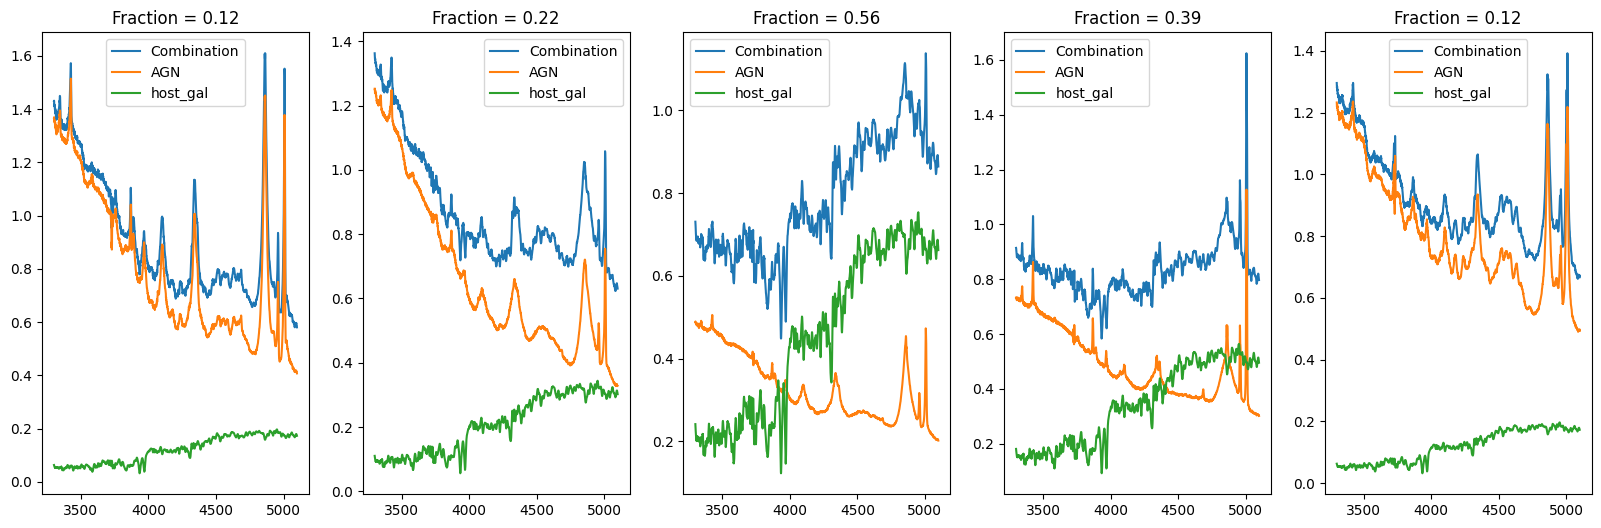

In [12]:
# Example datum
fig, ax = plt.subplots(figsize=(20,6), ncols=5)
for i in range(5):
  singleRow=firstDataset.iloc[[i]]
  wl= singleRow['wl'].iloc[0]
  flux= singleRow['flux'].iloc[0]
  true_AGN= singleRow['true_AGN'].iloc[0]
  true_gal= singleRow['true_gal'].iloc[0]
  f_gal= singleRow['f_gal'].iloc[0]


  ax[i].plot(wl, flux, label='Combination')
  ax[i].plot(wl, true_AGN, label='AGN')
  ax[i].plot(wl, true_gal, label='host_gal')
  ax[i].set_title('Fraction = '+str(f_gal))
  ax[i].legend()
print('No. of Wavelength bins = ',len(wl))

- **Composite quiescent galaxy** spectrum was made by taking the mean of a large number of quiescent galaxy spectra. These quiescent galaxies are **not forming stars, red in colour**, and elliptical.

- The AGN spectrum here is a bunch of templates from MFICA components. These are **free of any host galaxy light**. So they represent **only the light coming from the accretion disk of the black hole, its broad line region and its narrow-line region.**

In [13]:
# Dataset class
class tensorData(data.Dataset):
  def __init__(self, flux, fraction):
    self.data=flux
    self.label=fraction
    self.generateData()
    self.size=len(self.data)

  def generateData(self):
    self.tensordata=torch.Tensor(self.data)
    self.tensorlabel=torch.Tensor(self.label)

  # define __getitem__, and __len__ to define pytorch dataset, allows you use dataset[index] wihout needed to do dataset.getitem(index)
  def __getitem__(self, index):
    data_point = self.tensordata[index]
    data_label = self.tensorlabel[index]
    return data_point, data_label

  def  __len__(self):
    return self.size

fullDataset=tensorData(firstDataset['flux'], firstDataset['f_gal'])

In [14]:
trainDataset, testDataset = torch.utils.data.random_split(fullDataset, [4500,500])
trainDataset, validDataset = torch.utils.data.random_split(trainDataset, [4400,100])

In [15]:
train_data_loader = data.DataLoader(trainDataset, batch_size=40, num_workers=0, pin_memory=False ,shuffle=True)
valid_data_loader = data.DataLoader(validDataset, batch_size=100, shuffle=True)
test_data_loader = data.DataLoader(testDataset, batch_size=500, shuffle=True)

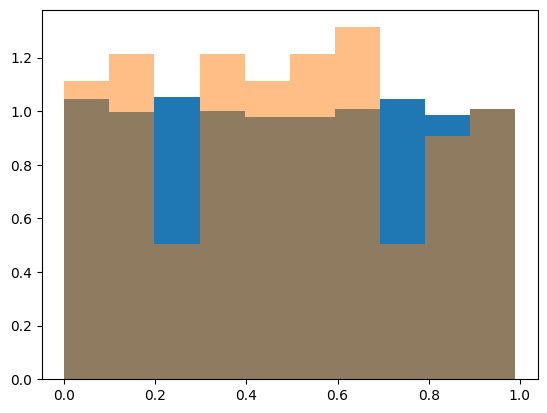

In [16]:
_=plt.hist(trainDataset[:][1],10, density=True)
_=plt.hist(validDataset[:][1],10, density=True, alpha=0.5)

## Training and Graphing Functions

In [25]:
def trainModelResNet(model, traindataLoader, validdataLoader, optimiser, lossCalculator, epochs, scheduler,logging_dir, verbose):
  writer=SummaryWriter(logging_dir)
  initBoard=False


  for epoch in tqdm(range(epochs)):
    epoch_train_loss=0
    epoch_valid_loss=0
    model.train()
    for batch_data, batch_label in traindataLoader:
      batch_data=batch_data.unsqueeze(1)
      batch_data=batch_data.to(device)
      batch_label=batch_label.to(device)


      if not initBoard:
        writer.add_graph(model, batch_data) # needs to be on gpu before calling this
        initBoard = True

      prediction=model(batch_data).squeeze()


      loss= lossCalculator(prediction, batch_label)
      #print(loss)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      epoch_train_loss += loss.item() # per batch, average over number of batches

    epoch_valid_loss+=validate_model(model, validdataLoader, lossCalculator) # per epoch



    # Add average loss to TensorBoard
    epoch_train_loss /= len(traindataLoader)


    scheduler.step(epoch_valid_loss)

    if verbose==True:
        if epochs > 60:
            if epoch%10 == 0:
                print('Epoch No:',epoch,'Train loss: ', epoch_train_loss, 'Valid loss:', epoch_valid_loss, 'lr', scheduler.get_last_lr()[0])
        else:
            print('Epoch No:',epoch,'Train loss: ', epoch_train_loss, 'Valid loss:', epoch_valid_loss, 'lr', scheduler.get_last_lr()[0])

    writer.add_scalars('Losses', {'traning_loss': epoch_train_loss,
                                'validation_loss': epoch_valid_loss},
                      global_step = epoch + 1)


    writer.add_scalar('Learning rate',scheduler.get_last_lr()[0], global_step=epoch+1)

    # writer.add_scalar('validation_loss',
    #               epoch_valid_loss,
    #               global_step = epoch + 1)



  writer.close()
  print('Epoch No:',epoch,'Train loss: ', epoch_train_loss, 'Valid loss:', epoch_valid_loss, 'lr', scheduler.get_last_lr()[0])
  return [epoch_train_loss, epoch_valid_loss]


def validate_model(model, validdataLoader, lossCalculator):
  model.eval()
  with torch.no_grad():
    lossValue=0
    for batch_data, batch_label in validdataLoader:
      batch_data=batch_data.unsqueeze(1)
      batch_data=batch_data.to(device)
      batch_label=batch_label.to(device)

      prediction=model(batch_data).squeeze()
      lossValue+=loss(prediction, batch_label)

    lossValue /= len(validdataLoader)
  return lossValue


#### Graph Function

In [18]:
def graphPredictionTruth(model, attempt, fig, ax):
    model.eval()

    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])

    frame2=fig.add_axes((.1,.25,.4,.75))
    frame1=fig.add_axes((.1,.01,.4,.25))


    for trial_batch in train_data_loader:
        with torch.no_grad():
            #trial_batch=next(iter(train_data_loader))
            trial_batch_p=trial_batch[:][0].to(device)
            trial_batch_t=trial_batch[:][1].to(device)

            predict=model(trial_batch_p.unsqueeze(1)).cpu().squeeze().detach().numpy()
        truth=trial_batch_t.cpu().detach().numpy()
        diff=truth-predict

        t = np.array(list(zip(predict, truth, diff)), dtype = [('predict', float), ('truth', float), ('diff', float)])
        t = np.sort(t, order=['truth'])[::-1]
        frame2.scatter(x=t['truth'], y=t['predict'], c='blue', alpha=0.2)
        frame2.plot([0,1],[0,1], c='orange')
        frame1.scatter(x=t['truth'], y=t['diff'], c='blue', alpha=0.2)


        frame1.set_xlabel('truth')
        frame2.set_ylabel('predict')
        frame1.set_ylabel('Truth-Prediction')
        ax[0].set_title(attempt+' Train')

        # worst10 = np.sort(t, order=['diff'])[::-1][0:10]
        # best10= np.sort(t, order=['diff'])[::-1][-10:-1]

        # ax[0].scatter(x=worst10['truth'], y=worst10['predict'], c='red')
        # ax[0].scatter(x=best10['truth'], y=best10['predict'], c='cyan')

    frame1.plot([0,1], [0,0], c='orange')
    # 2nd graph
    trial_batch_p=validDataset[:][0].to(device)
    trial_batch_t=validDataset[:][1].to(device)

    predict=model(trial_batch_p.unsqueeze(1)).cpu().squeeze().detach().numpy()
    truth=trial_batch_t.cpu().detach().numpy()
    diff=np.abs(truth-predict)

    t = np.array(list(zip(predict, truth, diff)), dtype = [('predict', float), ('truth', float), ('diff', float)])
    t = np.sort(t, order=['truth'])[::-1]
    ax[1].scatter(x=t['truth'], y=t['predict'])
    ax[1].plot([0,1],[0,1], c='orange')

    ax[1].set_xlabel('truth')
    ax[1].set_ylabel('predict')
    ax[1].set_title(attempt+' Valid')

## AlexNet

### Alexnet class and graphing

In [19]:
class convBlock(nn.Module):
    def __init__(self, input_ch, output_ch ,kernel, stride, LNBool, maxPoolBool, mpKernel, mpStride):
        super().__init__()

        pad=int((kernel-1)/2)
        mpPad=int((mpKernel-1)/2) if mpKernel != None else None
        self.conv=nn.Conv1d(input_ch, output_ch, kernel, stride, pad)
        self.act=nn.ReLU()
        self.LN=nn.LocalResponseNorm(size=5, k=2) if LNBool else None # params taken from (https://lightning.ai/jed/studios/alexnet-from-scratch-in-pytorch-lightning?section=featured)
        self.maxPool=nn.MaxPool1d(mpKernel, mpStride, mpPad) if maxPoolBool else None

    def forward(self,x):
        x=self.conv(x)
        x=self.act(x)
        x=self.LN(x) if self.LN != None else x
        x=self.maxPool(x) if self.maxPool != None else x
        return x

class fullyConnectedBlock(nn.Module):
    def __init__(self, input_ch, output_ch, dropoutBool, dropoutFrac, activationBool):
        super().__init__()
        self.lin=nn.Linear(input_ch, output_ch)
        self.dropout=nn.Dropout(dropoutFrac) if dropoutBool else None
        self.act=nn.ReLU() if activationBool else None

    def forward(self,x):
        x=self.lin(x)
        x=self.dropout(x) if self.dropout != None else x
        x=self.act(x) if self.act != None else x
        return x

class AlexNet(nn.Module):
    def __init__(self, input_ch, output_ch,hiddenlayerCh,fcLayerCh ):
        super().__init__()

        self.conv1=convBlock(input_ch, hiddenlayerCh[0], 11, 2, True, True, 3, 2)
        self.conv2=convBlock(hiddenlayerCh[0], hiddenlayerCh[1], 5, 1, True, True, 3, 2)
        self.conv3=convBlock(hiddenlayerCh[1], hiddenlayerCh[2], 3, 1, False, False, None, None)
        self.conv4=convBlock(hiddenlayerCh[2], hiddenlayerCh[3], 3, 1, False, False, None, None)
        self.conv5=convBlock(hiddenlayerCh[3], hiddenlayerCh[4], 3, 1, False, True, 3, 2)
        self.flatten=nn.Flatten()

        self.fc1=fullyConnectedBlock(119*hiddenlayerCh[-1],fcLayerCh,True,0.5,True) #256*119=30464
        self.fc2=fullyConnectedBlock(fcLayerCh,fcLayerCh,True,0.5,True)
        self.fc3=fullyConnectedBlock(fcLayerCh,1,False,None,False)

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        return x

    #         self.model=nn.Sequential(convBlock(input_ch, 96, 11, 2, True, True, 3, 2),
    #                              convBlock(96, 256, 5, 1, True, True, 3, 2),
    #                              convBlock(256, 384, 3, 1, False, False, None, None),
    #                              convBlock(384, 256, 3, 1, False, False, None, None),
    #                              convBlock(256, 256, 3, 1, False, True, 3, 2),
    #                              nn.Flatten(),
    #                              fullyConnectedBlock(256,4096,True,0.5,True),
    #                              fullyConnectedBlock(4096,4096,True,0.5,True),
    #                              fullyConnectedBlock(4096,1,False,None,False))
    # def forward(self,x):
    #     x=self.model(x)
    #     return x

In [34]:
#graph

def graphPredictionTruth_alex(model, attempt, ax):

    model.eval()

    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])

    frame2=fig.add_axes((.1,.25,.4,.75))
    frame1=fig.add_axes((.1,.01,.4,.25))

    for trial_batch in train_data_loader:
        with torch.no_grad():
            trial_batch_p=trial_batch[:][0].to(device) # actually full train set
            trial_batch_t=trial_batch[:][1].to(device)

            predict=model(trial_batch_p.unsqueeze(1)).cpu().squeeze().detach().numpy()
        truth=trial_batch_t.cpu().detach().numpy()
        diff=truth-predict

        t = np.array(list(zip(predict, truth, diff)), dtype = [('predict', float), ('truth', float), ('diff', float)])
        t = np.sort(t, order=['truth'])[::-1]
        # ax[0].scatter(x=t['truth'], y=t['predict'], c='blue', alpha=0.2)
        # ax[0].plot([0,1],[0,1], c='orange')

        # ax[0].set_xlabel('truth')
        # ax[0].set_ylabel('predict')
        # ax[0].set_title(attempt)

        frame2.scatter(x=t['truth'], y=t['predict'], c='blue', alpha=0.2)
        frame2.plot([0,1],[0,1], c='orange')
        frame1.scatter(x=t['truth'], y=t['diff'], c='blue', alpha=0.2)


        frame1.set_xlabel('truth')
        frame2.set_ylabel('predict')
        frame1.set_ylabel('Truth-Prediction')
        ax[0].set_title(attempt+' Train')

        # worst10 = np.sort(t, order=['diff'])[::-1][0:10]
        # best10= np.sort(t, order=['diff'])[::-1][-10:]

        # ax[0].scatter(x=worst10['truth'], y=worst10['predict'], c='red')
        # ax[0].scatter(x=best10['truth'], y=best10['predict'], c='cyan')
    frame1.plot([0,1],[0,0])
    with torch.no_grad():
        trial_batch_p=validDataset[:][0].to(device) # actually full train set
        trial_batch_t=validDataset[:][1].to(device)

        predict=model(trial_batch_p.unsqueeze(1)).cpu().squeeze().detach().numpy()
    truth=trial_batch_t.cpu().detach().numpy()
    diff=np.abs(truth-predict)

    t = np.array(list(zip(predict, truth, diff)), dtype = [('predict', float), ('truth', float), ('diff', float)])
    t = np.sort(t, order=['truth'])[::-1]
    ax[1].scatter(x=t['truth'], y=t['predict'])
    ax[1].plot([0,1],[0,1], c='orange')

    ax[1].set_xlabel('truth')
    ax[1].set_ylabel('predict')
    ax[1].set_title(attempt+' Valid')



### Attempts

#### Attempt 1 - Same as paper

In [ ]:
# need to define, model, loss module and optimizer
hiddenlayerCh=[96,256,384,256,256]
fcLayerCh=4096
alexNetModel=AlexNet(1,1, hiddenlayerCh,fcLayerCh)

loss= nn.MSELoss()
optimiser= torch.optim.SGD(alexNetModel.parameters(), lr=0.001, weight_decay=0.0001,momentum=0.9)
lrScheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min')


# train
log_dir= 'runs/results/'+ datetime.now().strftime("%Y%m%d-%H%M%S") + 'AlexNet'
alexNetModel.to(device)
trainModelResNet(alexNetModel, train_data_loader, valid_data_loader,optimiser, loss, 20, lrScheduler, log_dir, True)



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch No: 0 Train loss:  0.13160662007602777 Valid loss: tensor(0.0827) lr 0.001
Epoch No: 1 Train loss:  0.08460586460476571 Valid loss: tensor(0.0827) lr 0.001
Epoch No: 2 Train loss:  0.0844550234688954 Valid loss: tensor(0.0824) lr 0.001
Epoch No: 3 Train loss:  0.08424565023319287 Valid loss: tensor(0.0820) lr 0.001
Epoch No: 4 Train loss:  0.08391886323013088 Valid loss: tensor(0.0820) lr 0.001
Epoch No: 5 Train loss:  0.08342232250354507 Valid loss: tensor(0.0814) lr 0.001
Epoch No: 6 Train loss:  0.08283713432875546 Valid loss: tensor(0.0807) lr 0.001
Epoch No: 7 Train loss:  0.08192076794803142 Valid loss: tensor(0.0801) lr 0.001
Epoch No: 8 Train loss:  0.08058382035656408 Valid loss: tensor(0.0775) lr 0.001
Epoch No: 9 Train loss:  0.0780480578203093 Valid loss: tensor(0.0737) lr 0.001
Epoch No: 10 Train loss:  0.07210402976382863 Valid loss: tensor(0.0652) lr 0.001
Epoch No: 11 Train loss:  0.05844190110537139 Valid loss: tensor(0.0449) lr 0.001


In [ ]:
#graph
attempt='Attempt 1'
fig, ax=plt.subplots(figsize=(15,6), ncols=2)
graphPredictionTruth_alex(alexNetModel, attempt, ax)

#### Attempt 2 - Simpler

In [28]:
hiddenlayerCh=[16,42,64,42,42]
fcLayerCh=672
alexNetModel=AlexNet(1,1, hiddenlayerCh,fcLayerCh)

loss= nn.MSELoss()
optimiser= torch.optim.SGD(alexNetModel.parameters(), lr=0.001, weight_decay=0.0001,momentum=0.9)
lrScheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min')


# train
log_dir= 'runs/results/'+ datetime.now().strftime("%Y%m%d-%H%M%S") + 'AlexNet'
alexNetModel.to(device)
trainModelResNet(alexNetModel, train_data_loader, valid_data_loader,optimiser, loss, 20, lrScheduler, log_dir, True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch No: 0 Train loss:  0.13116131736473605 Valid loss: tensor(0.0831) lr 0.001
Epoch No: 1 Train loss:  0.08555572490123185 Valid loss: tensor(0.0830) lr 0.001
Epoch No: 2 Train loss:  0.08461676402525468 Valid loss: tensor(0.0825) lr 0.001
Epoch No: 3 Train loss:  0.0849352898245508 Valid loss: tensor(0.0827) lr 0.001
Epoch No: 4 Train loss:  0.08463028012351556 Valid loss: tensor(0.0823) lr 0.001
Epoch No: 5 Train loss:  0.08475674018263817 Valid loss: tensor(0.0823) lr 0.001
Epoch No: 6 Train loss:  0.08466027978469025 Valid loss: tensor(0.0821) lr 0.001
Epoch No: 7 Train loss:  0.08435499221086502 Valid loss: tensor(0.0820) lr 0.001
Epoch No: 8 Train loss:  0.08443395813757723 Valid loss: tensor(0.0819) lr 0.001
Epoch No: 9 Train loss:  0.08387481732801957 Valid loss: tensor(0.0816) lr 0.001
Epoch No: 10 Train loss:  0.08327199593186378 Valid loss: tensor(0.0813) lr 0.001
Epoch No: 11 Train loss:  0.08311254930767147 Valid loss: tensor(0.0809) lr 0.001
Epoch No: 12 Train loss:  0

[0.010299551152539525, tensor(0.0022)]

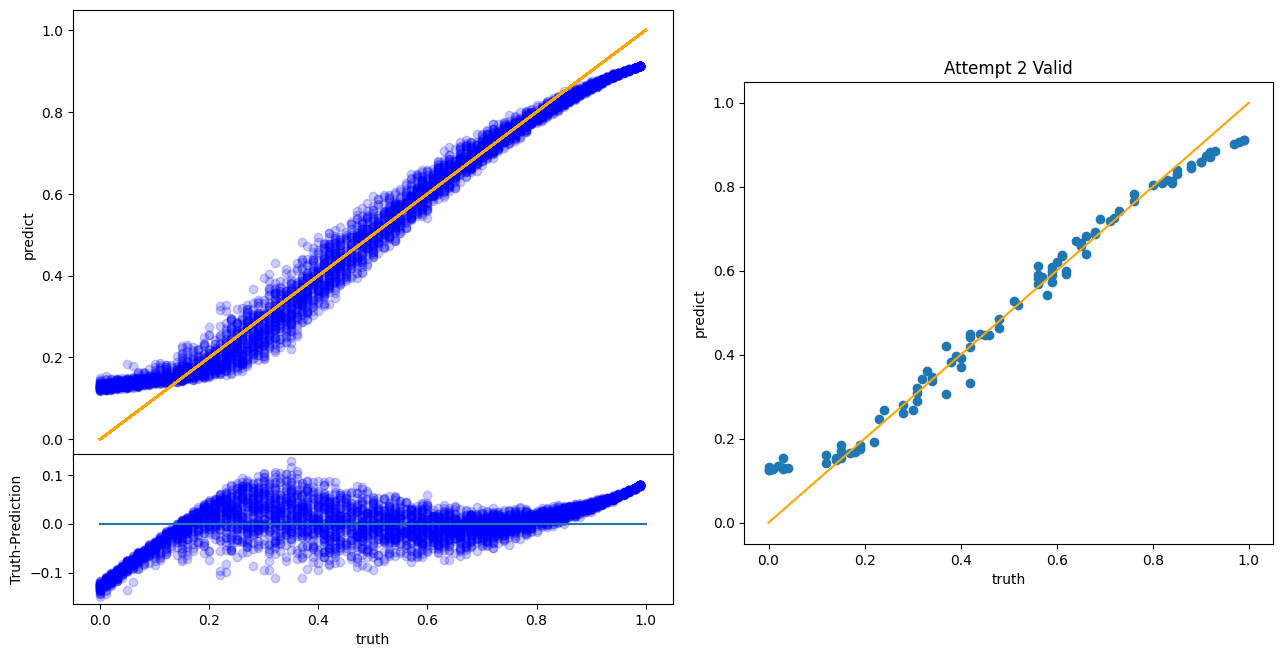

In [35]:
#graph
attempt='Attempt 2'
fig, ax=plt.subplots(figsize=(15,6), ncols=2)
graphPredictionTruth_alex(alexNetModel, attempt, ax)